# Future Model Runs

Let us do some research now, with help of the [CMIP6 dataset](https://pcmdi.llnl.gov/CMIP6/).
We will look how our model fares with historical CMIP data and their climate models that predict future scenarios.
I have setup some possible climate change models for you to use, you have to fill in your camel ID and think of a research question!

We like the sentence:
- To understand [environment issue] in [region] we will study te impact of [verb/noun] on [hydrological variable].

But feel free to come up with your own!
Some hints:
- Maybe look at a smaller time period.
- What do certain climate changes do to your region.

## In This Notebook: Model runs with CMIP Forcing

In this notebook we will do the model runs for the chosen areas with the generated forcing from the previous notebook.
This will be used to do our research with!

## Importing and setting up

In [1]:
# Ignore user warnings :)
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Required dependencies
import ewatercycle.forcing
import ewatercycle.observation.grdc
import ewatercycle.analysis
from pathlib import Path
from cartopy.io import shapereader
import pandas as pd
import numpy as np
from rich import print
import xarray as xr
import shutil
import ewatercycle
import ewatercycle.models

from util_functions import *

**TO DO**

Change to your region here, you can change the folder structure as well, but note that you will have to change that in upcoming notebooks as well!

In [2]:
# Copy your camel ID from previous Notebook
camel_id = "AF_1531450.0"

In [6]:
# Defining path for catchment shape file
central_path = "/data/datasets/ghana/camel_data"

path_to_save = Path.home() / "my_data/workshop_ghana"
path_to_save.mkdir(exist_ok=True, parents=True)

shape_file = central_path + "/shapefiles" + f"/{str(camel_id[:-2])}" + f"/{str(camel_id[:-2])}.shp"
data_file_nc = central_path + (f"/{camel_id}.nc")

my_data_nc = xr.open_dataset(data_file_nc, engine="netcdf4")

# Defining destination path for CMIP data
forcing_path_CMIP = path_to_save / "CMIP_forcing"
forcing_path_CMIP.mkdir(exist_ok=True)

# Model HBV destination path
model_path_HBV = path_to_save / "CMIP_HBV"
model_path_HBV.mkdir(exist_ok=True)

In [7]:
historical_start = "1975-01-01"
historical_end = "1979-12-31"

future_start_data = "2026-01-01"
future_end_data = "2099-12-31"

## Loading in the CMIP forcings

In [8]:
# Load the generated historical data
historical_location = forcing_path_CMIP / "historical" / "work" / "diagnostic" / "script" 
historical = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=historical_location)

# Load the generated SSP126 data
ssp126_location = forcing_path_CMIP / "SSP126" / "work" / "diagnostic" / "script" 
SSP126 = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=ssp126_location)

# Load the generated SSP245 data
ssp245_location = forcing_path_CMIP / "SSP245" / "work" / "diagnostic" / "script" 
SSP245 = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=ssp245_location)

# Load the generated SSP585 data
ssp585_location = forcing_path_CMIP / "SSP585" / "work" / "diagnostic" / "script" 
SSP585 = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=ssp585_location)

**TO DO**

Enter your found parameters here!

In [9]:
# Add your parameters here, dont change the FM below, keep it at 0.001
parameters_found = [
    10.0,   # Imax - Interception capacity [mm]
    0.87,   # Ce - Soil runoff coefficient [-]
    592.0,  # Sumax - Max soil moisture storage [mm]
    1.4,    # Beta - Shape parameter for runoff generation [-]
    0.3,    # Pmax - Percolation threshold [mm/day]
    1.0,    # Tlag - Routing lag time [days]
    0.1,    # Kf - Fast runoff recession coefficient [1/day]
    0.01,   # Ks - Slow runoff recession coefficient [1/day]
    0.001   # FM - Snowmelt factor (not critical in Ghana, can remain low)
]

#               Si,  Su, Sf, Ss, Sp
s_0 = np.array([0,  100,  0,  5,  0])

## Setting up the models

I took this bit from our Bachelor student Ischa, so thank you very much!
We put the forcings in a list and then we will use that to look through the models we created, using the BMI implementation.
NOTE: we use ```HBVLocal``` here to speed up the process. This is a model that just runs locally, without the setup of containers, which is proportionally heavier than the running of the actual model.

In [10]:
forcing_list = [SSP126, SSP245, SSP585, historical]
output = []
years = []

for forcings in forcing_list:
    model = ewatercycle.models.HBVLocal(forcing=forcings)
    config_file, _ = model.setup(
        parameters=parameters_found, 
        initial_storage=s_0,
        cfg_dir = model_path_HBV,
    )

    model.initialize(config_file)

    Q_m = []
    time = []
    
    while model.time < model.end_time:
        model.update()
        Q_m.append(model.get_value("Q")[0])
        time.append(pd.Timestamp(model.time_as_datetime))
        
    output.append(Q_m)
    years.append(time)
    
    del Q_m, time
    model.finalize()

## Checking our results
Finally, we look at the output and we use standard python libraries to visualize the results. We put the model output into a pandas Series to make plotting easier.

In [11]:
SSP126_output = pd.Series(data=output[0], name="SSP126", index=years[0])
SSP245_output = pd.Series(data=output[1], name="SSP245", index=years[1])
SSP585_output = pd.Series(data=output[2], name="SSP585", index=years[2])
historical_output = pd.Series(data=output[3], name="Historical", index=years[3])

# Saving the data for the next Notebook
SSP126_output.to_pickle(forcing_path_CMIP / "SSP126" / "output.pkl")
SSP245_output.to_pickle(forcing_path_CMIP / "SSP245" / "output.pkl")
SSP585_output.to_pickle(forcing_path_CMIP / "SSP585" / "output.pkl")
historical_output.to_pickle(forcing_path_CMIP / "historical" / "output.pkl")

Looking at the historical data modelling first.

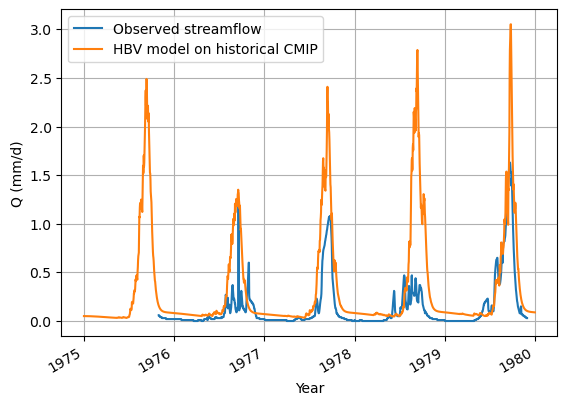

In [12]:
my_data_nc['streamflow'].sel(date=slice(historical_start, historical_end)).plot(label="Observed streamflow")
historical_output.plot(label="HBV model on historical CMIP")
plt.ylabel("Q (mm/d)")
plt.xlabel("Year")
plt.grid()
plt.legend()
plt.show()

Now for the visualising you will look at the model outputs, which is, as you will see, pointless for this many years.

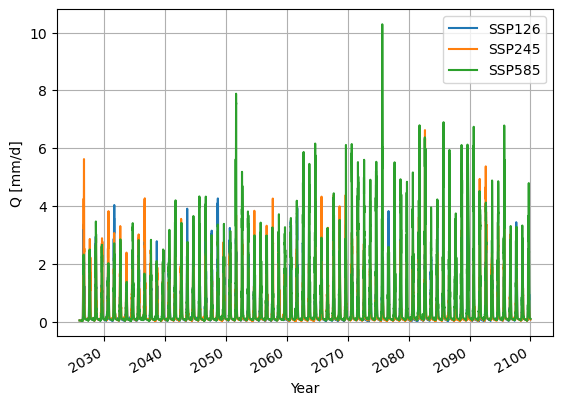

In [13]:
SSP126_output.plot()
SSP245_output.plot()
SSP585_output.plot()
plt.ylabel("Q [mm/d]")
plt.xlabel("Year")
plt.grid()
plt.legend()
plt.show()

## Done with the model runs

Now go to the next Notebook to do some research!